# Street Network Analysis: Nodes and Paths
## Working with OSM data

In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import geopandas as gpd
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import cityImage as ci

## Important: find EPSG of your case-study area
### Specify the name of the city for convenience

In [2]:
#initialise path, names, etc.
city_name = 'Muenster'
epsg = 25832
crs = 'EPSG:'+str(epsg)

In [14]:
nodes =  gpd.read_file('Outputs/Muenster/Muenster_nodes.shp').to_crs(crs)
edges = gpd.read_file('Outputs/Muenster/Muenster_edges.shp').to_crs(crs)
nodes.index = nodes.nodeID
edges.index = edges.edgeID
nodes.index.name = None
edges.index.name = None
nodes["x"], nodes["y"] = list(zip(*[(r.coords[0][0], r.coords[0][1]) for r in nodes.geometry]))

In [15]:
edges = ci.correct_edges(nodes, edges)

In [16]:
# Creating the dual geodataframes and the dual graph.
nodesDual_graph, edgesDual_graph = ci.dual_gdf(nodes, edges, epsg)
dual_graph = ci.dual_graph_fromGDF(nodesDual_graph, edgesDual_graph)

In [17]:
edges['length'] = edges.geometry.length

In [18]:
crs = 'EPSG:'+str(epsg)
saving_path = 'Outputs/'+city_name+'/'

# primal graph
nodes.crs, edges.crs = crs, crs
nodes.to_file(saving_path+city_name+'_nodes.shp', driver='ESRI Shapefile')
edges.to_file(saving_path+city_name+'_edges.shp', driver ='ESRI Shapefile')

# dual graph
nodesDual_graph.crs, edgesDual_graph.crs = crs, crs
nodesDual_graph.drop('intersecting', axis=1).to_file(saving_path+city_name+'_nodesDual.shp', driver = 'ESRI Shapefile')
edgesDual_graph.to_file(saving_path+city_name+'_edgesDual.shp', driver = 'ESRI Shapefile')

## 1. Downloading the data from OpenStreetMap

Choose the name of the place that represent your case-study area. When the case-study area does not coincide with the entire extension of a city, it is suggested to include the case-study area's surroundings (e.g. buffer of 2000 mt from the centre of the area, depending on its extension) so to avoid the edge effect when computing the centrality measures.

Choose between the following methods:
* `OSMplace`, provide an OSM place name (e.g. City).
* `polygon`, provide a polygon in the WGS coordinate system to clip the area of interest.
* `distance_from_address`, provide a precise address and define parameter "distance" (which is otherwise not necessary)

In [35]:
place = 'Domplatz, Muenster, Germany'
download_method = 'distance_from_address'
distance = 2500

nodes_graph, edges_graph = ci.get_network_fromOSM(place, download_method, 'walk', distance = distance, epsg = epsg)

## 2 Cleaning and simplyfing the Street Network - gdf

At the end of the previous section two files are obtained: nodes and edges (vertexes, or links). Below, before creating the actual graph, the two datasets are cleaned, simplified and corrected.

Cleaning functions handle:
* Duplicate geometries (nodes, edges).
* Pseudo-nodes.
* Disconnected islands - `remove_disconnected_islands`
* Dead-ends - `dead_ends`
* Self-Loops - `self_loops`
* Same u-v nodes edges, with different geometries - `same_uv_edges`

`same_uv_edges` regulates the handling of edges with same pair of u-v nodes but different geometries.
When true keeps a center line between the two segments, unless one of the two segments is longer than the other (>10%). In this case, the longer segment is deleted.

It also:

* Fix topology - breaks lines at intersections with other lines in the streets GeoDataFrame, apart from segments categorised as bridges or tunnels in OSM - `fix_topology`

In [36]:
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_disconnected_islands = True,
                            same_uv_edges = True, self_loops = True, fix_topology = False)

# not mandatory: it may create distortion in the network representation! (check the simplification jupyter notebook for details:

In [ ]:
nodes_graph, edges_graph = ci.simplify_pipeline(nodes_graph, edges_graph, radius = 10)

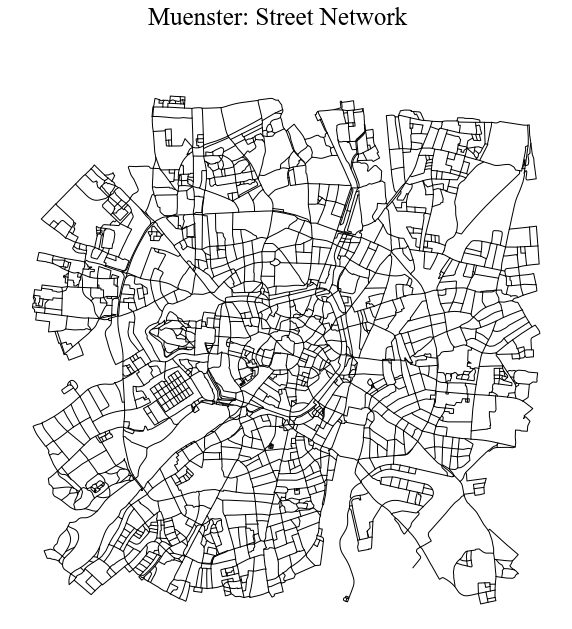

In [8]:
fig = ci.plot_gdf(edges_graph, black_background = False, fig_size = 10, title = city_name+': Street Network', color = 'black')

In [41]:
# Obtaining the graph from the case-study area and computing the centrality measures
graph = ci.graph_fromGDF(nodes_graph, edges_graph)

## 3. - Nodes centrality

On the primal graph representation of the street network, the following centrality measures are computed on nodes, on the basis of road distance:

* Road Distance Shortest Path Betweenness centrality (`Bc_Rd`).
* Information Centrality (`Bc_Rw`)
* Straightness centrality (`Sc`) (see [Crucitti et al. 2006](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.73.036125)).
* Reach centrality (`Rc_400`, `Rc_600`) (readataped from [Sevtsuk & Mekonnen 2012](https://www.sutd.edu.sg/cmsresource/idc/papers/2012_Urban_Network_Analysis_A%20New%20Toolbox_for_ArcGIS.pdf)) - it measures the importance of a node based on the number of services (e.g. commercial activities) reachable by that node (for instance within a buffer).

The first measure (`Bc_Rd`) is used to identify Lynchian nodes.

`measure` accepts `betweenness_centrality`, `information_centrality`, `straightness_centrality`, `closeness_centrality`.
The function returns dictionaries, which are going to be merged in the GDF below.

In [42]:
# betweenness centrality
Bc_Rd = ci.centrality(graph, nodes_graph, measure = "betweenness_centrality", weight = 'length', normalized = False)
# information centrality
Bc_Rw =  ci.centrality(graph, nodes_graph, measure ="information_centrality", weight = 'length', normalized = False)
# straightness centrality
Sc = ci.centrality(graph, nodes_graph, measure = "straightness_centrality", weight = 'length', normalized = False)

#### Choose which of the following amenities you consider relevant as "services" for computing reach centrlality. Check [OSM amenities](https://wiki.openstreetmap.org/wiki/Key:amenity) for details

In [43]:
amenities = ['arts_centre', 'atm', 'bank', 'bar', 'bbq', 'bicycle_rental', 'bicycle_repair_station', 'biergarten', 
             'boat_rental', 'boat_sharing', 'brothel', 'bureau_de_change', 'cafe', 'car_rental', 'car_sharing', 'car_wash', 'casino', 'childcare',
           'cinema', 'clinic', 'college', 'community_centre', 'courthouse', 'crematorium', 'dentist', 'dive_centre', 'doctors', 
           'driving_school', 'embassy', 'fast_food', 'ferry_terminal', 'fire_station', 'food_court', 'fuel', 'gambling', 'gym', 
           'hospital', 'ice_cream', 'internet_cafe', 'kindergarten', 'kitchen', 'language_school', 'library', 'marketplace', 
           'monastery', 'motorcycle_parking', 'music_school', 'nightclub', 'nursing_home', 'pharmacy', 'place_of_worship', 
           'planetarium', 'police', 'post_office', 'prison', 'pub', 'public_building', 'ranger_station', 'restaurant', 'sauna',
           'school', 'shelter', 'shower', 'social_centre', 'social_facility', 'stripclub', 'studio', 'swingerclub', 'theatre', 
           'toilets', 'townhall', 'university', 'veterinary']

In [44]:
# reach centrality pre-computation, in relation to Point of Interests or any other point-geodataframes 
place = 'Domplatz, Muenster, Germany'
services = ox.geometries.geometries_from_address(place, dist = 2500, tags = {'amenity':True}).to_crs(epsg=epsg)
services = services[services.amenity.isin(amenities)]
services = services[services['geometry'].geom_type == 'Point']

# using a 50 mt buffer
graph = ci.weight_nodes(nodes_graph, services, graph, field_name = 'services',  radius = 50)

# Reach Centrality
Rc400 = ci.reach_centrality(graph, weight = 'length', radius = 400, attribute = 'services') 
Rc600 = ci.reach_centrality(graph, weight = 'length', radius = 600, attribute = 'services')

In [45]:
## Appending the attributes to the geodataframe
dicts = [Bc_Rd, Bc_Rw, Sc, Rc400, Rc600]
columns = ['Bc_Rd', 'Bc_Rw', 'Sc', 'Rc400', 'Rc600']
for n,c in enumerate(dicts): 
    nodes_graph[columns[n]] = nodes_graph.nodeID.map(c)

c:\users\g_filo01\miniconda3\envs\cityimage\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3.1 Nodes' centrality - Visualisation

In [16]:
col = ['Bc_Rd', 'Bc_Rw', 'Sc', 'Rc400', 'Rc600']
titles = ['Betweennes Centrality - Shortest Path', 'Betweennes Centrality - Random Walker', 
         'Straightness Centrality', 'Reach Centrality 400 mt radius', 'Reach Centrality 600 mt radius']

#### Parameters 

* `black_background` black background or white
* `fig_size`: size of the figure's side extent
* `scheme`: the classification method, choose amongst: https://pysal.org/mapclassify/api.html
* `bins`: bins defined by the user
* `classes`: nr classes for visualising when scheme is not "None"
* `norm`: a desired data normalisation into a [min, max] interval
* `cmap`: see matplotlib colormaps for a list of possible values or pass a colormap
* `color`: categorical color applied to all geometries when not using a column to color them
* `alpha`: alpha value of the plotted layer
* `legend`: if True, show legend, otherwise don't

* `axes_frame`: if True, it shows an axis frame
* `ms` point size value, when plotting a Point GeoDataFrame
* `ms_factor`: when provided, it rescales the column provided, if any, from 0 to 1 and it uses the ms_factor to rescale the marker size accordingly (e.g. rescaled variable's value [0-1] * factor), when plotting a Point GeoDataFrame
* `lw`: line width, when plotting a LineString GeoDataFrame
* `lw_factor`: when provided, it rescales the column provided, if any, from 0 to 1 and it uses the lw_factor to rescale the line width accordingly (e.g. rescaled variable's value [0-1] * factor), when plotting a LineString GeoDataFrame

* `cbar`: if True, show colorbar, otherwise don't; when True it doesn't show legend. Related paramters are:
    * `cbar_ticks`:  number of ticks along the colorbar
    * `cbar_max_symbol`:  if True, it shows the ">" next to the highest tick's label in the colorbar (useful when normalising)
    *  `only_min_max`: if True, it only shows the ">" and "<" as labels of the lowest and highest ticks' the colorbar

* `gdf_base_map`, provide a GeoDataFrame that should be used as base-map. Related paramters are:        
    * `gdf_base_map`: a desired additional layer to use as a base map        
    * `base_map_color`color applied to all geometries of the base map
    * `base_map_alpha`: base map's alpha value
    * `base_map_ms`: base map's marker size when the base map is a Point GeoDataFrame
    * `base_map_lw`: base map's line width when the base map is a LineString GeoDataFrame
    * `base_map_zorder`: zorder of the layer; e.g. if 0, plots first, thus main GeoDataFrame on top; if 1, plots last, thus on top.

#### Grid visualisation

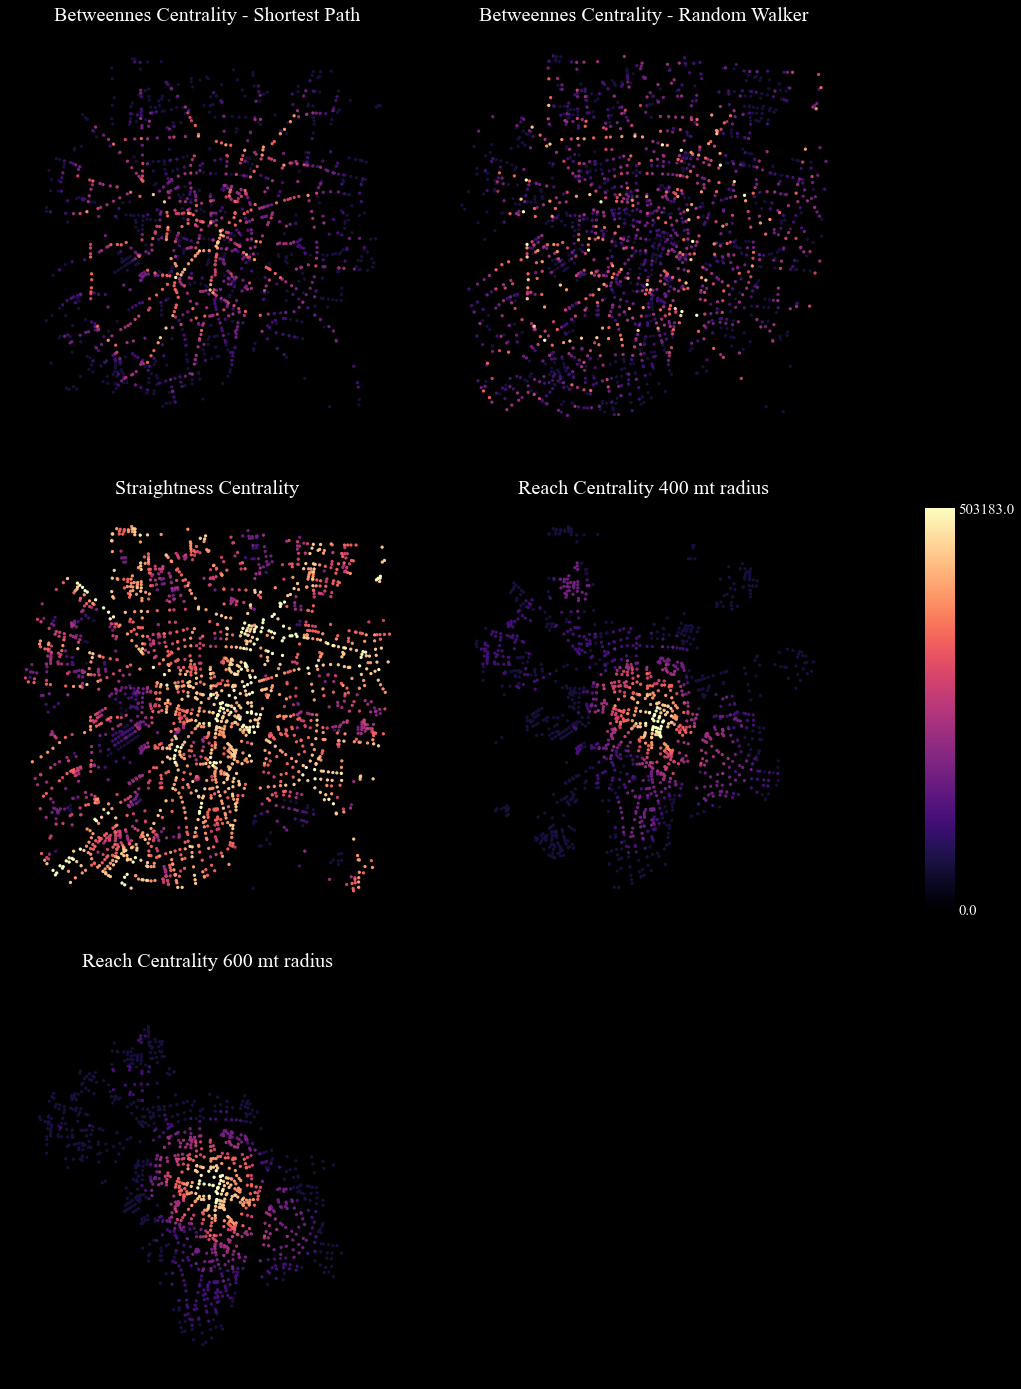

In [17]:
fig = ci.plot_gdf_grid(nodes_graph, titles = titles, columns = col, classes = 10, cmap = 'magma', fig_size = 15, ms = 5,
                   scheme = 'natural_breaks', cbar = True, only_min_max = True)

#### Single figure visualisation with Lynch-like Breaks

c:\users\g_filo01\miniconda3\envs\cityimage\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


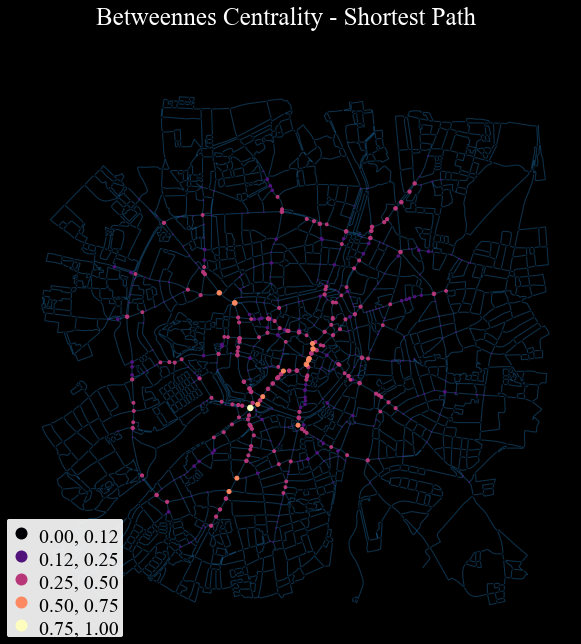

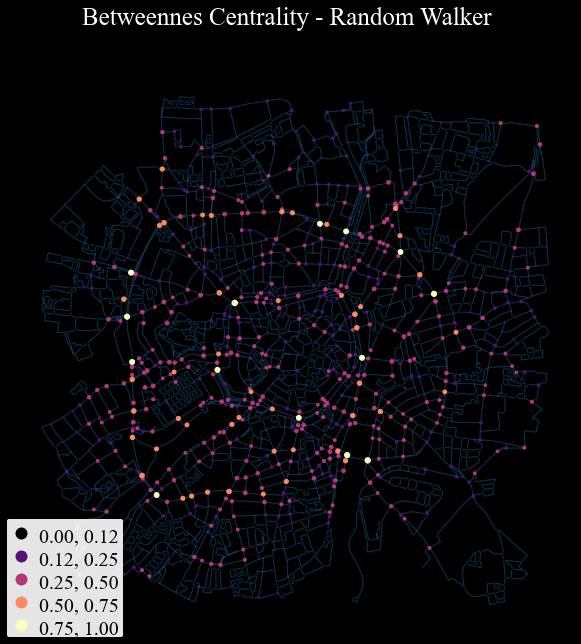

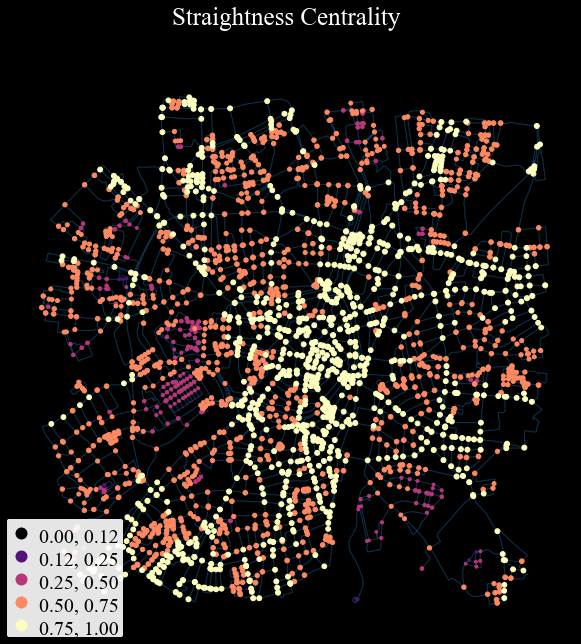

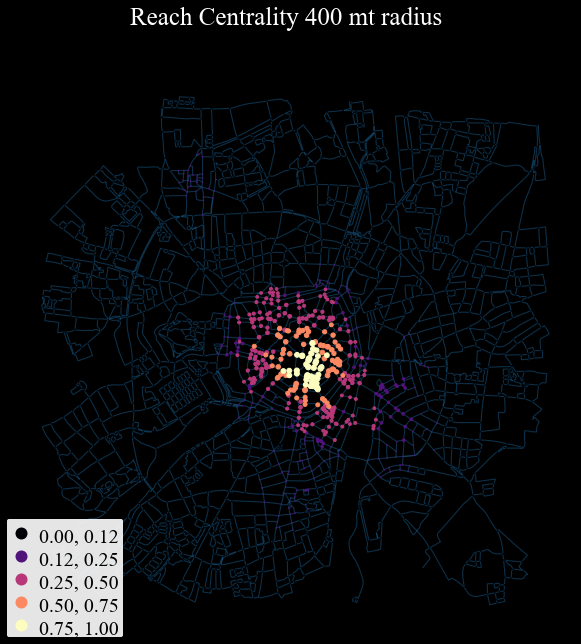

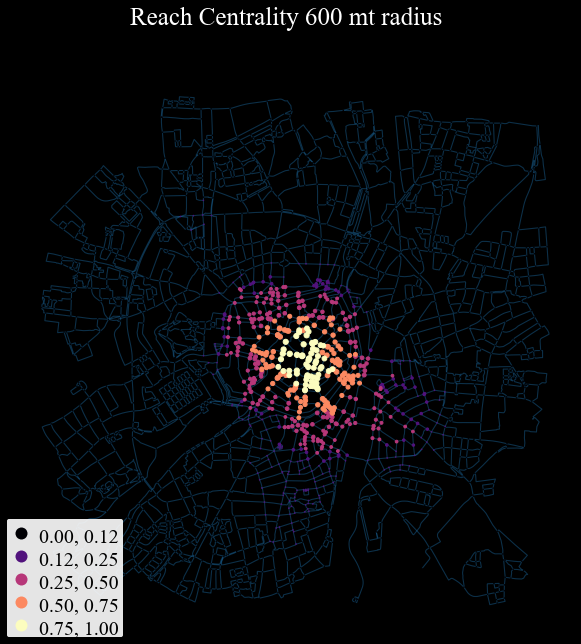

In [22]:
for n, column in enumerate(columns):
    ci.plot_gdf(nodes_graph, column = column, title = titles[n], cmap = 'magma', ms_factor = 30, fig_size = 10,
                   scheme ='Lynch_Breaks', gdf_base_map = edges_graph, base_map_zorder = 0, legend = True)

## 4. Paths

On the primal graph representation of the street network, the following centrality measures are computed on edges:
* Road Distance Betweenness centrality.
* Angular Betweenness centrality (On the dual graph representation of the street network)

In [46]:
# Road Distance betweenness centrality
Eb = nx.edge_betweenness_centrality(graph, weight = 'length', normalized = False)

In [47]:
# appending to the geodataframe
if 'Eb' in edges_graph.columns:
    edges_graph.drop(['Eb'], axis = 1, inplace = True)
edges_graph = ci.append_edges_metrics(edges_graph, graph, [Eb], ['Eb'])

### 4.1 Dual graph analysis

Here street-segments are transformed into nodes (geograpically represented by their centroids). Fictional links represent instead intersections. Thus if two segments are connected in the actual street network, a link in the dual graph representation will be created by connecting the corresponding nodes. 
This process allows to take advantage of angular relationships in centrality measures computation and other network operations.

In [48]:
# Creating the dual geodataframes and the dual graph.
nodesDual_graph, edgesDual_graph = ci.dual_gdf(nodes_graph, edges_graph, epsg)
dual_graph = ci.dual_graph_fromGDF(nodesDual_graph, edgesDual_graph)

c:\users\g_filo01\miniconda3\envs\cityimage\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


c:\users\g_filo01\miniconda3\envs\cityimage\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


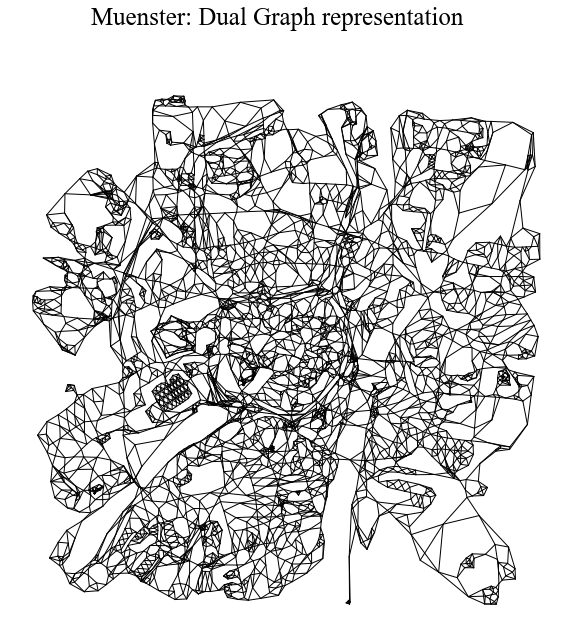

In [27]:
fig = ci.plot_gdf(edgesDual_graph, black_background = False, fig_size = 10, title = city_name+': Dual Graph representation', 
         color = 'black')

In [49]:
# Angular-change betweenness centrality
Ab = nx.betweenness_centrality(dual_graph, weight = 'rad', normalized = False)
edges_graph['Ab'] = edges_graph.edgeID.map(Ab)

c:\users\g_filo01\miniconda3\envs\cityimage\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 4.2 Paths (Edges' centrality) visualisation

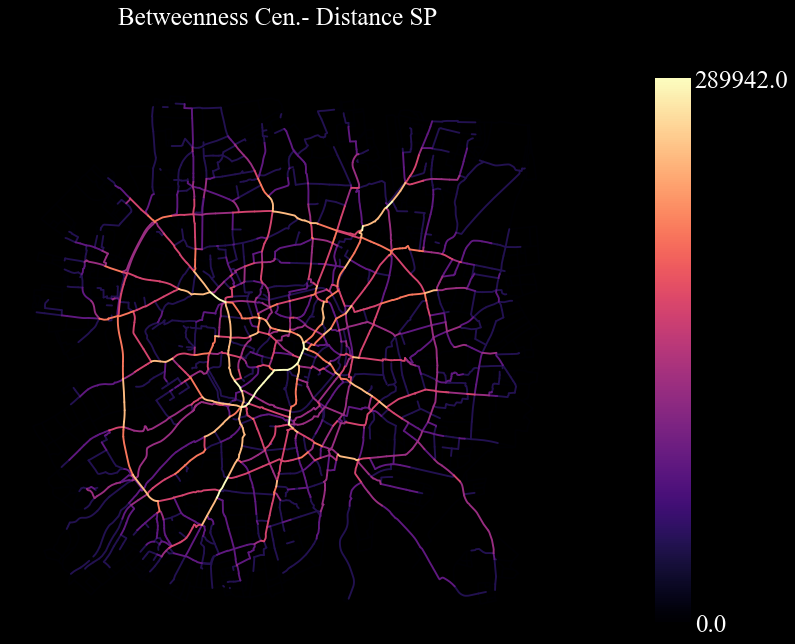

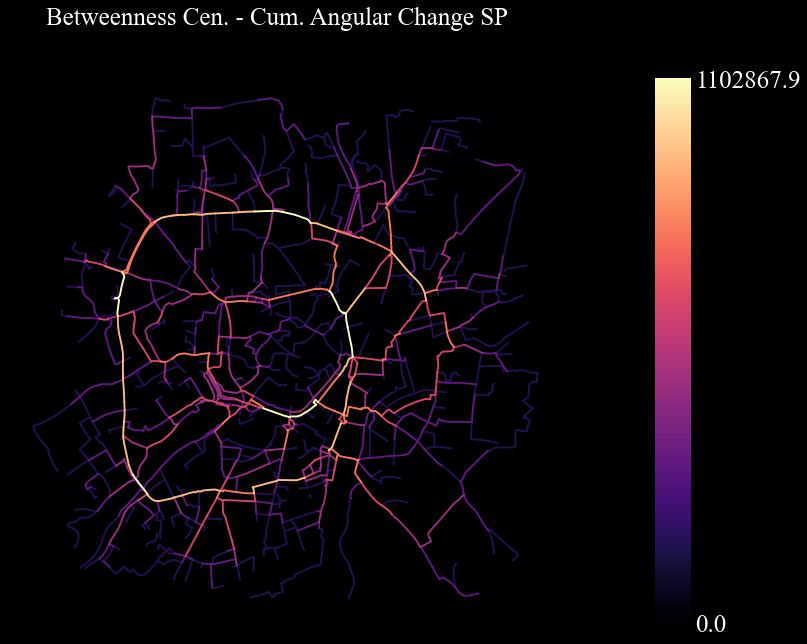

In [50]:
columns = ['Eb', 'Ab']
titles = ['Betweenness Cen.- Distance SP', 'Betweenness Cen. - Cum. Angular Change SP']

for n, column in enumerate(columns):
    ci.plot_gdf(edges_graph, classes = 8, column = column, title = titles[n], lw = 1.9, 
                  scheme = 'Natural_Breaks', cmap = 'magma', fig_size = 10, cbar = True, only_min_max = True)

## Exporting

In [51]:
# provide path
crs = 'EPSG:'+str(epsg)
saving_path = 'Outputs/'+city_name+'/'

# primal graph
nodes_graph.crs, edges_graph.crs = crs, crs
nodes_graph.to_file(saving_path+city_name+'_nodes.shp', driver='ESRI Shapefile')
edges_graph.to_file(saving_path+city_name+'_edges.shp', driver ='ESRI Shapefile')

# dual graph
nodesDual_graph.crs, edgesDual_graph.crs = crs, crs
nodesDual_graph.drop('intersecting', axis=1).to_file(saving_path+city_name+'_nodesDual.shp', driver = 'ESRI Shapefile')
edgesDual_graph.to_file(saving_path+city_name+'_edgesDual.shp', driver = 'ESRI Shapefile')

c:\users\g_filo01\miniconda3\envs\cityimage\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\users\g_filo01\miniconda3\envs\cityimage\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
